In [1]:
import sys
import json
import warnings

import numpy as np
import pandas as pd
import scanpy as sc
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../..')
from scanpy import AnnData
from itertools import chain
from matplotlib.colors import LinearSegmentedColormap
from utils import UnimapResult, set_plot_theme, generate_positions


set_plot_theme()
warnings.filterwarnings('ignore')

/home/hht/.conda/envs/unimap1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
s_data = sc.read_h5ad('../../data/mg/mg_ref.h5ad')
t_data = sc.read_h5ad('../../data/mg/mg_query.h5ad')

s_data.obs['domain'] = 'source'
t_data.obs['domain'] = 'target'
raw_data = sc.concat([s_data, t_data], join='outer')
sc.tl.pca(raw_data, svd_solver='arpack')
sc.pp.neighbors(raw_data, n_neighbors=10, n_pcs=40)
sc.tl.umap(raw_data)

result = UnimapResult('mg', f'unimap/2023', root_dir='../../results', detailed=False)

color_dict = json.load(open('../../color_dict.json'))
batch_c = color_dict["mg_batch"]
ct_c = color_dict["mg_ct_query"]
pd_ct_c = color_dict["mg_ct_ref"]

ref_ct_l = result.s_result['celltype']
ct_w_l = result.s_result['pred_celltype_prob'].rank(method='dense', ascending=True)
query_ct_l = ['reference'] * len(result.s_result) + list(result.t_result['celltype'])
query_pd_ct_l = ['reference'] * len(result.s_result) + list(result.t_result['pred_celltype'])

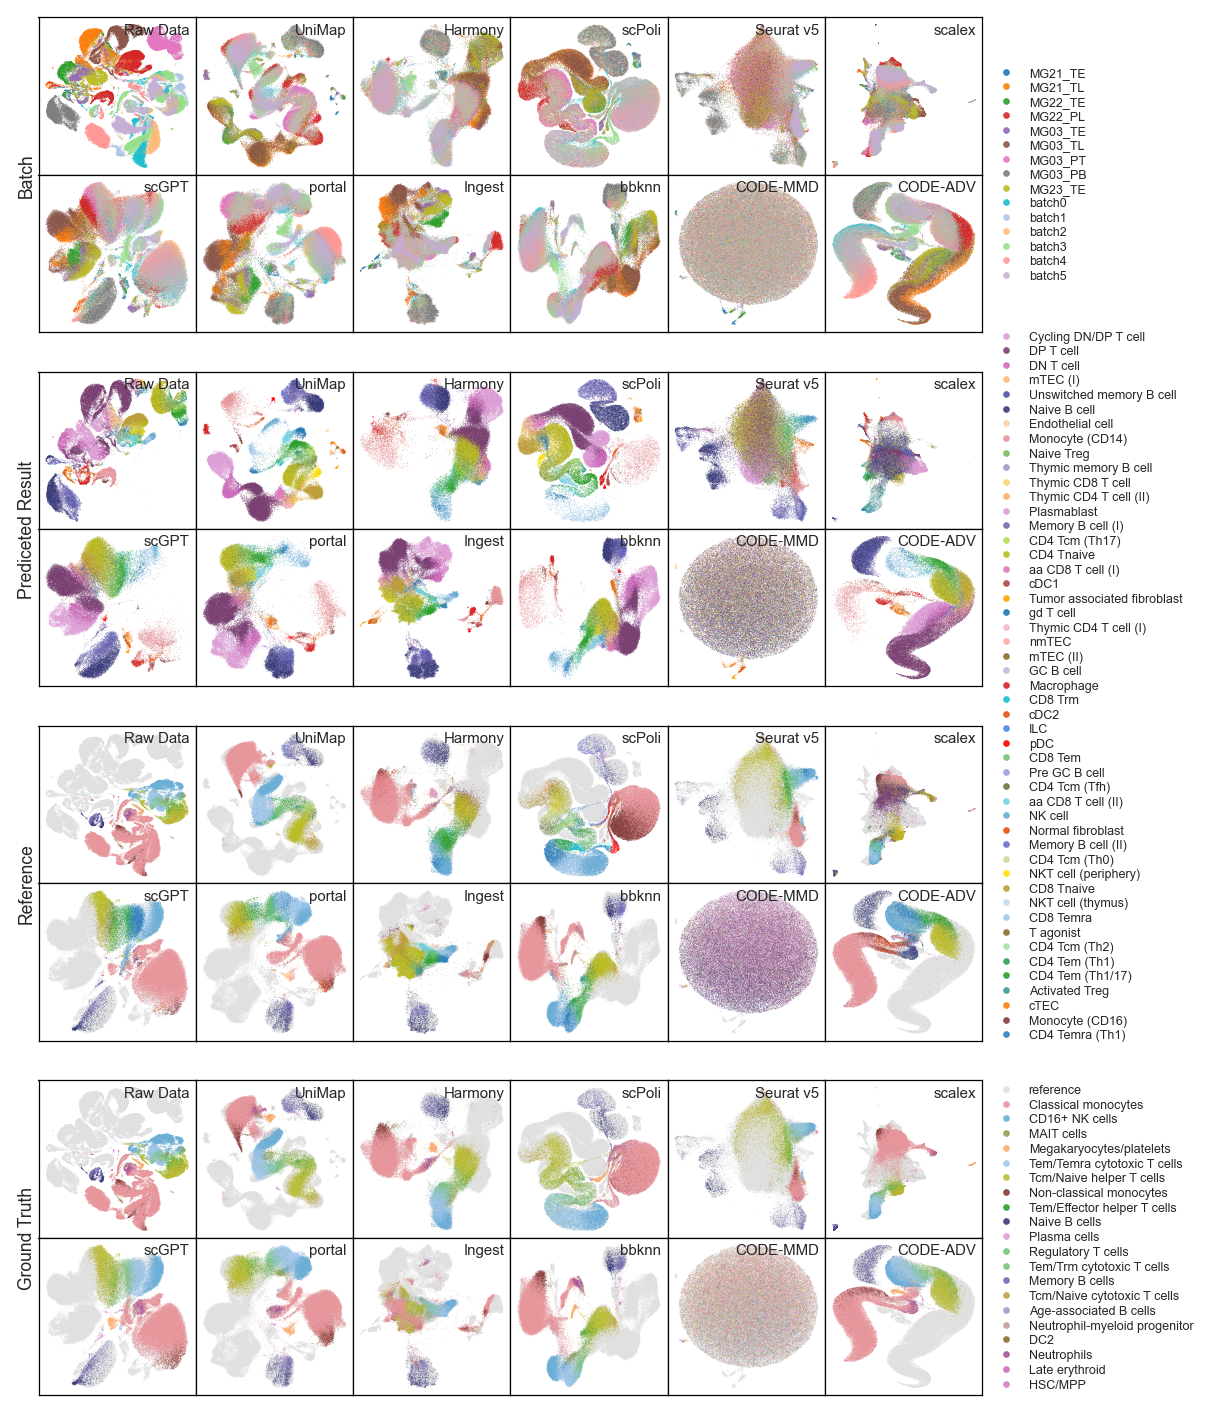

In [ ]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()


models = ['raw_data', 'unimap', 'harmony', 'scpoli', 'seurat',  'scalex', 'scgpt', 'portal', 'ingest', 'bbknn', 'code_mmd', 'code_adv']
models_name =  ['Raw Data', 'UniMap', 'Harmony', 'scPoli', 'Seurat v5', 'scalex', 'scGPT', 'portal', 'Ingest', 'bbknn', 'CODE-MMD', 'CODE-ADV']

position1 = generate_positions(w=0.12, h=0.12 / (250/185), l=0.06, b=0.8)
position2 = generate_positions(w=0.12, h=0.12 / (250/185), l=0.06, b=0.6)
position3 = generate_positions(w=0.12, h=0.12 / (250/185), l=0.06, b=0.4)
position4 = generate_positions(w=0.12, h=0.12 / (250/185), l=0.06, b=0.2)

for idx, model in enumerate(models):
    model_name = models_name[idx]
    if model == 'raw_data':
        umap1 = raw_data.obsm['X_umap'][:, 0]
        umap2 = raw_data.obsm['X_umap'][:, 1]

        batch_labels = raw_data.obs.batch
        ref_labels = ['reference'] * sum(raw_data.obs['domain']  ==  'source')
        ct_labels = list(raw_data[raw_data.obs.domain == 'source'].obs.celltype)
        pd_ct_labels = ref_labels + list(raw_data[raw_data.obs.domain == 'target'].obs.celltype)
        ground_truth = ref_labels + list(raw_data[raw_data.obs.domain == 'target'].obs.celltype)
    else:
        result = UnimapResult('mg', f'{model}/2023', root_dir='../../results', detailed=False)
        umap1 = result.st_umap_result['umap1']
        umap2 = result.st_umap_result['umap2']

        batch_labels = list(result.st_result.batch)
        ref_labels = ['reference'] * len(result.s_result['domain'])
        ct_labels = list(result.s_result.celltype)
        pd_ct_labels = ref_labels + list(result.t_result.pred_celltype)
        ground_truth = ref_labels + list(result.t_result.celltype)
    

    ax1 = fig.add_axes(position1[idx])
    ax2 = fig.add_axes(position2[idx])
    ax3 = fig.add_axes(position3[idx])
    ax4 = fig.add_axes(position4[idx])
    
    s = 0.05
    p1 = sns.scatterplot(x=umap1, y=umap2,
    alpha=0.9, s=s, hue=batch_labels, edgecolor='none', palette=batch_c,                                    ax=ax1, rasterized=True)

    p3 = sns.scatterplot(x=umap1[:len(ct_labels)], y=umap2[:len(ct_labels)],
    alpha=0.9, s=s, hue=ct_labels,    edgecolor='none', palette=pd_ct_c,                                    ax=ax2, rasterized=True)

    p2 = sns.scatterplot(x=umap1, y=umap2,
    alpha=0.9, s=s, hue=pd_ct_labels, edgecolor='none', palette=(ct_c if model == 'raw_data' else pd_ct_c), ax=ax3, rasterized=True)

    p4 = sns.scatterplot(x=umap1, y=umap2,
    alpha=0.9, s=s, hue=ground_truth, edgecolor='none', palette=ct_c,                                       ax=ax4, rasterized=True)
    

    p1 = result.remove_ticks(p1, remove_legend=True)
    p2 = result.remove_ticks(p2, remove_legend=True)
    p3 = result.remove_ticks(p3, remove_legend=True)
    p4 = result.remove_ticks(p4, remove_legend=True)

    p1yl = p1.set_ylabel('' if idx != 0 else 'Batch',             fontsize=7, labelpad=1)
    p2yl = p2.set_ylabel('' if idx != 0 else 'Reference',         fontsize=7, labelpad=1)
    p3yl = p3.set_ylabel('' if idx != 0 else 'Prediceted Result', fontsize=7, labelpad=1)
    p4yl = p4.set_ylabel('' if idx != 0 else 'Ground Truth',      fontsize=7, labelpad=1)
    p1yl.set_position((0, 0.0))
    p2yl.set_position((0, 0.0))
    p3yl.set_position((0, 0.0))
    p4yl.set_position((0, 0.0))
    p1.text(0.96, (0.92), model_name, ha='right', va='center', transform=p1.transAxes, fontsize=6)
    p2.text(0.96, (0.92), model_name, ha='right', va='center', transform=p2.transAxes, fontsize=6)
    p3.text(0.96, (0.92), model_name, ha='right', va='center', transform=p3.transAxes, fontsize=6)
    p4.text(0.96, (0.92), model_name, ha='right', va='center', transform=p4.transAxes, fontsize=6)

    if idx == len(models) - 1:
        p1.legend(loc='center left', bbox_to_anchor=(1, 1), frameon=False, markerscale=12, fontsize=5, labelspacing=0.2)
        p3.legend(loc='center left', bbox_to_anchor=(1, 0), frameon=False, markerscale=12, fontsize=5, labelspacing=0.2)
        p4.legend(loc='center left', bbox_to_anchor=(1, 1), frameon=False, markerscale=12, fontsize=5, labelspacing=0.2)

fig.savefig('../figs/supplementary fig9.pdf', dpi=720)
fig.savefig('../sup_figs/sup9.png', dpi=720)

In [ ]:
ct_order = color_dict["mg_ct_order"]
pd_ct_order = color_dict["mg_pd_ct_order"]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#f4f3f8', '#827fbb'] )
positions = [[0.3, 0.76, 0.5, 0.18],
             [0.3, 0.55, 0.5, 0.18],
             [0.3, 0.34, 0.5, 0.18],
             [0.3, 0.13, 0.5, 0.18],]
models  = ['unimap', 'harmony', 'scpoli', 'seurat']
models2 = ['scalex', 'scgpt', 'portal', 'ingest']
models3 = ['bbknn', 'code_mmd', 'code_adv']

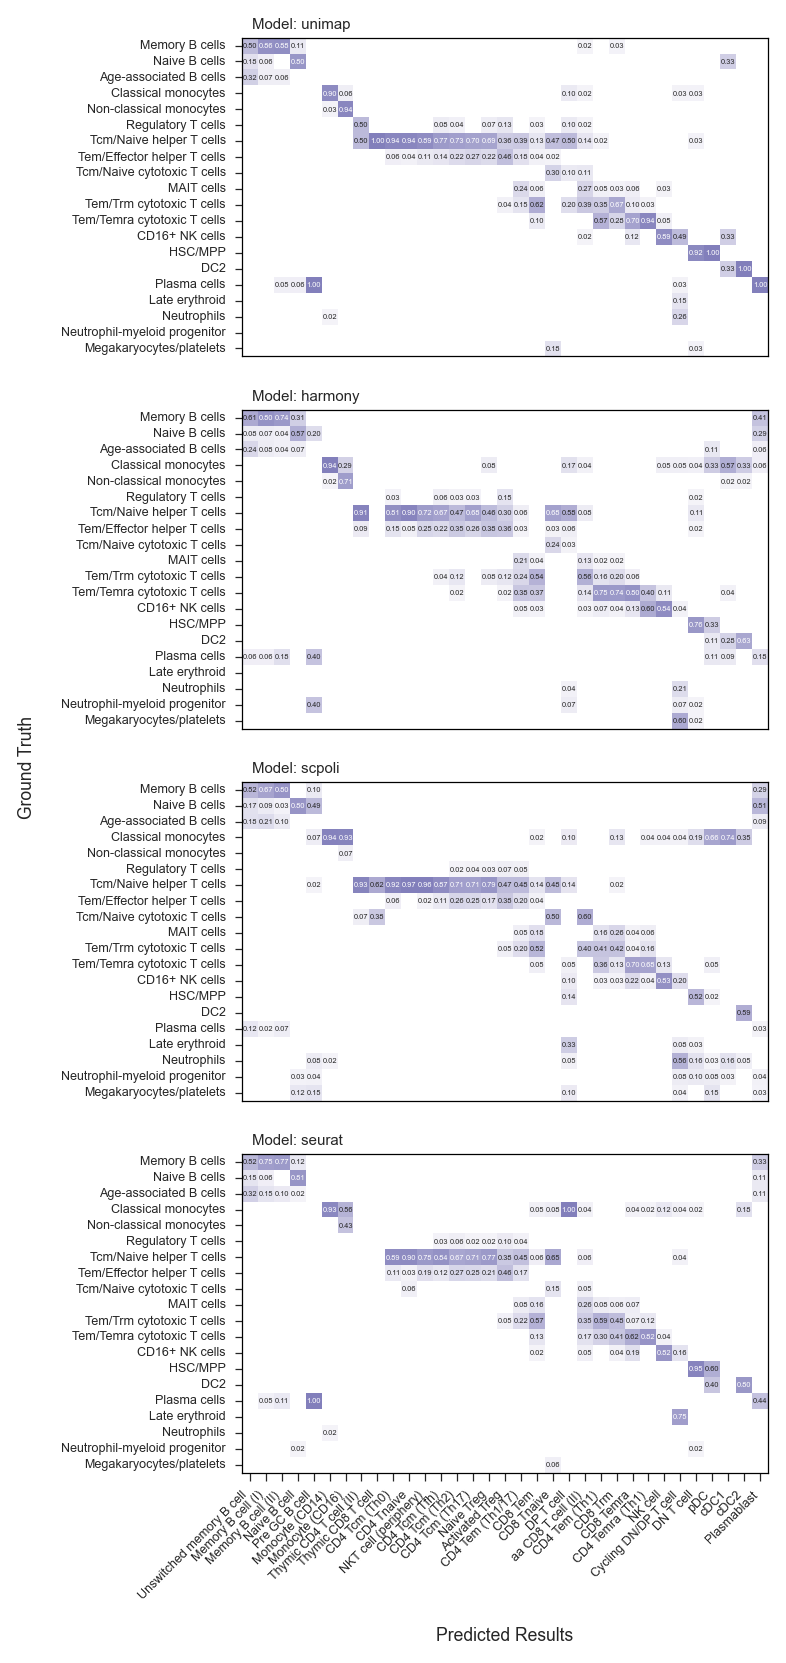

In [ ]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()

for idx, model in enumerate(models):
    result = UnimapResult('mg', f'{model}/2023', root_dir='../../results', detailed=False)

    cm = result.get_cm(percentage_direction=1, ct_labels=ct_order, pd_ct_labels=pd_ct_order)
    ax = sns.heatmap(cm, annot=True, cmap=custom_cmap, annot_kws={'size': 3}, fmt='.2f', cbar=False, square=True, mask=cm < 0.02, ax=fig.add_axes(positions[idx]), xticklabels=pd_ct_order, yticklabels=ct_order)
    result.remove_spines(ax, sp_v=True, remove_legend=False)
    ax.text(0.02, 1.04, f'Model: {model}', ha='left', va='center', transform=ax.transAxes, fontdict={'fontsize': 6})
    ax.set_yticklabels(ct_order, rotation=0, fontsize=5)
    ax.tick_params(bottom=False, top=False, left=True, right=False, length=3, width=0.5)
    if idx == 3:
        ax.set_xticklabels(pd_ct_order, rotation=45, ha='right', fontsize=5)
        ax.tick_params(bottom=True, top=False, left=True, right=False, length=3, width=0.5)
        ax.set_xlabel('Predicted Results', fontsize=7, labelpad=10)
    else:
        ax.set_xticklabels([])

    if idx == 1:
        ylabel = ax.set_ylabel('Ground Truth', fontsize=7, labelpad=10)
        ylabel.set_position((0, -0.12))
# fig.savefig('../figs/supplementary fig10a.pdf', dpi=720)
# fig.savefig('../sup_figs/sup10a.png', dpi=720)

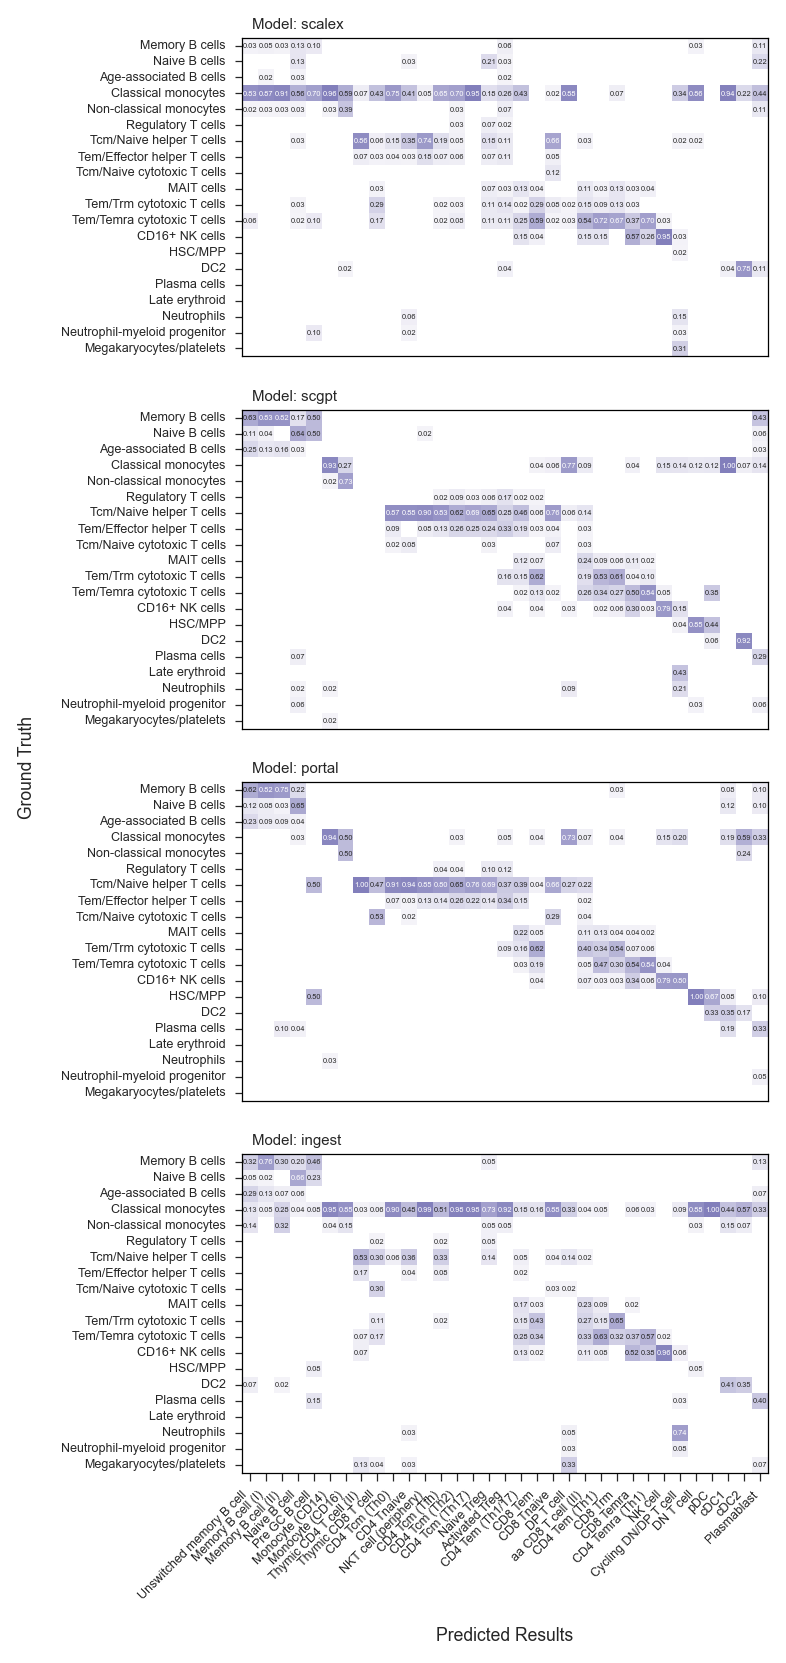

In [ ]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()

for idx, model in enumerate(models2):
    result = UnimapResult('mg', f'{model}/2023', root_dir='../../results', detailed=False)

    cm = result.get_cm(percentage_direction=1, ct_labels=ct_order, pd_ct_labels=pd_ct_order)
    ax = sns.heatmap(cm, annot=True, cmap=custom_cmap, annot_kws={'size': 3}, fmt='.2f', cbar=False, square=True, mask=cm < 0.02, ax=fig.add_axes(positions[idx]), xticklabels=pd_ct_order, yticklabels=ct_order)
    result.remove_spines(ax, sp_v=True, remove_legend=False)
    ax.text(0.02, 1.04, f'Model: {model}', ha='left', va='center', transform=ax.transAxes, fontdict={'fontsize': 6})
    ax.set_yticklabels(ct_order, rotation=0, fontsize=5)
    ax.tick_params(bottom=False, top=False, left=True, right=False, length=3, width=0.5)
    if idx == 3:
        ax.set_xticklabels(pd_ct_order, rotation=45, ha='right', fontsize=5)
        ax.tick_params(bottom=True, top=False, left=True, right=False, length=3, width=0.5)
        ax.set_xlabel('Predicted Results', fontsize=7, labelpad=10)
    else:
        ax.set_xticklabels([])

    if idx == 1:
        ylabel = ax.set_ylabel('Ground Truth', fontsize=7, labelpad=10)
        ylabel.set_position((0, -0.12))
# fig.savefig('../figs/supplementary fig10b.pdf', dpi=720)
# fig.savefig('../sup_figs/sup10b.png', dpi=720)

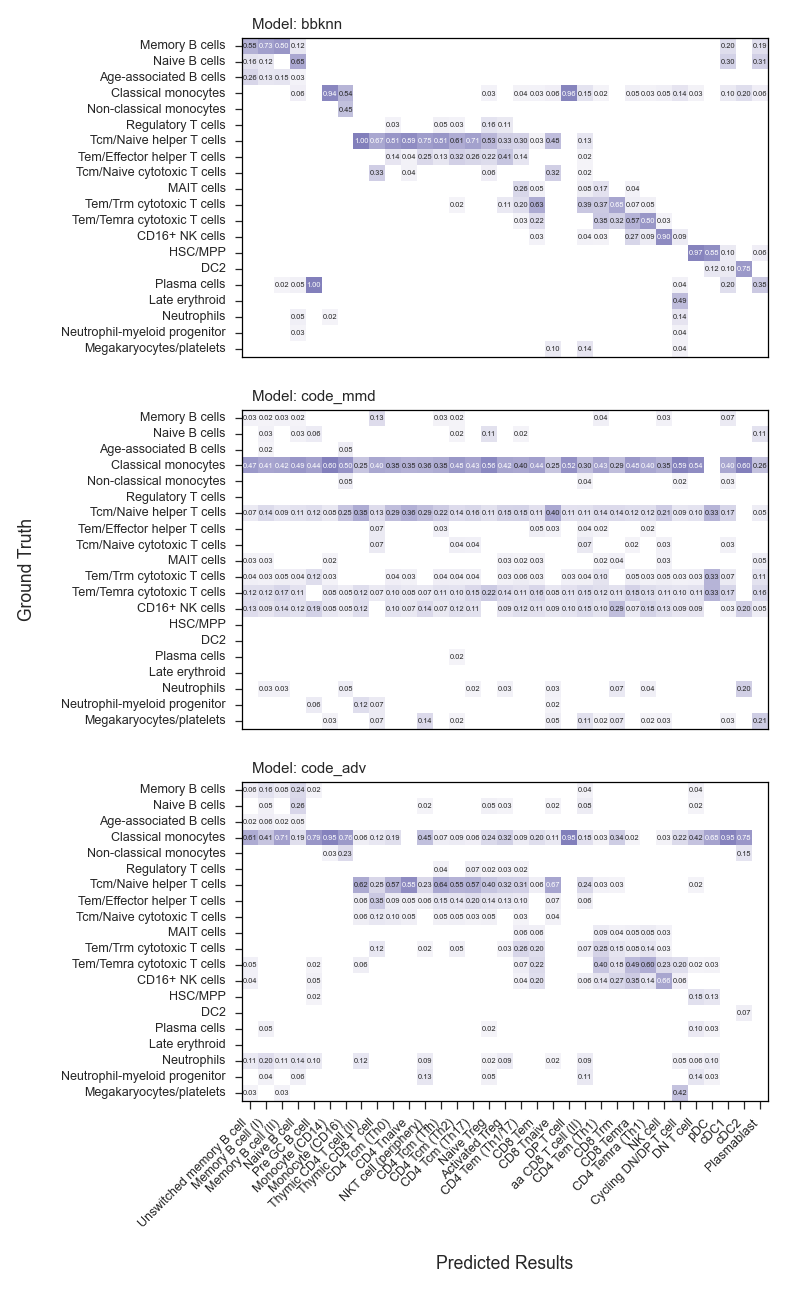

In [7]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()

for idx, model in enumerate(models3):
    result = UnimapResult('mg', f'{model}/2023', root_dir='../../results', detailed=False)

    cm = result.get_cm(percentage_direction=1, ct_labels=ct_order, pd_ct_labels=pd_ct_order)
    ax = sns.heatmap(cm, annot=True, cmap=custom_cmap, annot_kws={'size': 3}, fmt='.2f', cbar=False, square=True, mask=cm < 0.02, ax=fig.add_axes(positions[idx]), xticklabels=pd_ct_order, yticklabels=ct_order)
    result.remove_spines(ax, sp_v=True, remove_legend=False)
    ax.text(0.02, 1.04, f'Model: {model}', ha='left', va='center', transform=ax.transAxes, fontdict={'fontsize': 6})
    ax.set_yticklabels(ct_order, rotation=0, fontsize=5)
    ax.tick_params(bottom=False, top=False, left=True, right=False, length=3, width=0.5)
    if idx == 2:
        ax.set_xticklabels(pd_ct_order, rotation=45, ha='right', fontsize=5)
        ax.tick_params(bottom=True, top=False, left=True, right=False, length=3, width=0.5)
        ax.set_xlabel('Predicted Results', fontsize=7, labelpad=10)
    else:
        ax.set_xticklabels([])

    if idx == 1:
        ylabel = ax.set_ylabel('Ground Truth', fontsize=7, labelpad=10)
        # ylabel.set_position((0, -0.12))
# fig.savefig('../figs/supplementary fig10c.pdf', dpi=720)
# fig.savefig('../sup_figs/sup10c.png', dpi=720)